# Get start_Step1

Define a function for solving the NCPO problems with given standard deviations of process noise and observtion noise, length of  estimation data and required relaxation level.

* mount drive
* set envirment
* install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest")

Mounted at /content/drive


In [2]:
!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest"
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content/drive/MyDrive/Colab Notebooks"

In [3]:
### for colab ###
# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem.
# Install MOSEK and ncpol2sdpa if not already installed
!pip install mosek torch
!pip install ncpol2sdpa
!pip install networkx
!pip install gcastle==1.0.3rc2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ncpol2sdpa: filename=ncpol2sdpa-1.12.2-py3-none-any.whl size=70796 sha256=4688765eab4e313a6e9628caae31acdcd576ed45cd0a61a723ec611d38a94935
  Stored in directory: /root/.cache/pip/wheels/5b/d7/fe/ab61f3bf30a350feab3bb4dccd63932d56cbbd32b9ec0d94fa
Successfully built ncpol2sdpa
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 1.9 MB/s eta 0:00:00


# NCPOLR_Step2 ##
* NCPOLR (estimate_1hidden, estimate_2hidden)
* ANM_NCPO (learn, anmNCPO_estimate)

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
# from inputlds import*
# from functions import*
from ncpol2sdpa import*
from math import sqrt


import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
from inputlds import*
from functions import*
from ncpol2sdpa import*
from math import sqrt


class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()

    def estimate_1hidden(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.5*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate_2hidden(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model with 2*2 hidden state matrix and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        H = generate_operators("H", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=2, hermitian=True, commutative=False)
        m = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=True)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=True)
        n = generate_operators("n", n_vars=T, hermitian=True, commutative=False)
        u = generate_operators("u", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.0005*sum(p[i]**2 for i in range(T)) + 0.001*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [ f[i] - Fdash[0]*m[i]  - Fdash[1]*m[i-1] - p[i] for i in range(1,T)]
        ine2 = [-f[i] + Fdash[0]*m[i] +Fdash[1]*m[i-1] + p[i] for i in range(1,T)]
        ine3 = [ m[i] - G*m[i-1]  - H*m[i-2] - q[i] for i in range(2,T)]
        ine4 = [-m[i] + G*m[i-1] + H*m[i-2] + q[i] for i in range(2,T)]
        ine5 = [p[i] + n[i] for i in range(T)]
        ine6 = [p[i] - n[i] for i in range(T)]
        ine7 = [q[i] + u[i] for i in range(T)]
        ine8 = [q[i] - u[i] for i in range(T)]

        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,H,Fdash,f,p,m,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[Y[i]-f[i]+q[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return



class ANM_NCPO(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data,causalmodelling, columns=None, regressor=NCPOLR(),test_method=hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        causalmodelling: Modelling type(hidden_state1,hidden_state2,ARMA,Discrete)
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[1]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)),
                                    index=data.columns,
                                    columns=data.columns)

        for i, j in combinations(range(node_num), 2):
            x = data[:, i]
            y = data[:, j]
            xx = x.reshape((-1, 1))
            yy = y.reshape((-1, 1))

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.anmNCPO_estimate(x, y, causalmodelling, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.anmNCPO_estimate(y, x, causalmodelling, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def anmNCPO_estimate(self, x, y, causalmodelling, regressor=NCPOLR(), test_method=hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        causalmodelling: Modelling type(hidden_state1,hidden_state2,ARMA,Discrete)
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x)
        y = scale(y)
        if causalmodelling == 'hidden_state1':
            y_res = regressor.estimate_1hidden(x, y)
        elif causalmodelling == 'hidden_state2':
            y_res = regressor.estimate_2hidden(x, y)
        else:
            print('WRONG MODELLING TYPE')
        #if causalmodelling='ARMA':
        #if causalmodelling='Discrete':


        flag = test_method(np.asarray(y_res).reshape((-1, 1)), np.asarray(x).reshape((-1, 1)), alpha=self.alpha)
        print(flag)

        return flag





# Test_BuiltinDataSet_Step3
* erdos_renyi function
Set Gauss_linear/Nonlinear, nodes, edges and DataSize

In [14]:
# coding=utf-8
# 2020.12 added (1) low rank DAG generations;
#               (2) quad functons for causal functions;
#               (3) event-type data
# 2021.08 deleted (1) condition: sem_type == 'poisson'
# Huawei Technologies Co., Ltd.
#
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Copyright (c) Xun Zheng (https://github.com/xunzheng/notears)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import random
from random import sample
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from tqdm import tqdm
from copy import deepcopy
from itertools import combinations
from scipy.special import expit as sigmoid


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


class DAG(object):
    '''
    A class for simulating random (causal) DAG, where any DAG generator
    method would return the weighed/binary adjacency matrix of a DAG.
    Besides, we recommend using the python package "NetworkX"
    to create more structures types.
    '''

    @staticmethod
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    @staticmethod
    def _random_acyclic_orientation(B_und):
        B = np.tril(DAG._random_permutation(B_und), k=-1)
        B_perm = DAG._random_permutation(B)
        return B_perm

    @staticmethod
    def _graph_to_adjmat(G):
        return nx.to_numpy_array(G)

    @staticmethod
    def _BtoW(B, d, w_range):
        U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
        U[np.random.rand(d, d) < 0.5] *= -1
        W = (B != 0).astype(float) * U
        return W

    @staticmethod
    def _low_rank_dag(d, degree, rank):
        """
        Simulate random low rank DAG with some expected degree.

        Parameters
        ----------
        d: int
            Number of nodes.
        degree: int
            Expected node degree, in + out.
        rank: int
            Maximum rank (rank < d-1).

        Return
        ------
        B: np.nparray
            Initialize DAG.
        """
        prob = float(degree) / (d - 1)
        B = np.triu((np.random.rand(d, d) < prob).astype(float), k=1)
        total_edge_num = np.sum(B == 1)
        sampled_pa = sample(range(d - 1), rank)
        sampled_pa.sort(reverse=True)
        sampled_ch = []
        for i in sampled_pa:
            candidate = set(range(i + 1, d))
            candidate = candidate - set(sampled_ch)
            sampled_ch.append(sample(candidate, 1)[0])
            B[i, sampled_ch[-1]] = 1
        remaining_pa = list(set(range(d)) - set(sampled_pa))
        remaining_ch = list(set(range(d)) - set(sampled_ch))
        B[np.ix_(remaining_pa, remaining_ch)] = 0
        after_matching_edge_num = np.sum(B == 1)

        # delta = total_edge_num - after_matching_edge_num
        # mask B
        maskedB = B + np.tril(np.ones((d, d)))
        maskedB[np.ix_(remaining_pa, remaining_ch)] = 1
        B[maskedB == 0] = 1

        remaining_ch_set = set([i + d for i in remaining_ch])
        sampled_ch_set = set([i + d for i in sampled_ch])
        remaining_pa_set = set(remaining_pa)
        sampled_pa_set = set(sampled_pa)

        edges = np.transpose(np.nonzero(B))
        edges[:, 1] += d
        bigraph = nx.Graph()
        bigraph.add_nodes_from(range(2 * d))
        bigraph.add_edges_from(edges)
        M = nx.bipartite.maximum_matching(bigraph, top_nodes=range(d))
        while len(M) > 2 * rank:
            keys = set(M.keys())
            rmv_cand = keys & (remaining_pa_set | remaining_ch_set)
            p = sample(rmv_cand, 1)[0]
            c = M[p]
            # destroy p-c
            bigraph.remove_edge(p, c)
            M = nx.bipartite.maximum_matching(bigraph, top_nodes=range(d))

        new_edges = np.array(bigraph.edges)
        for i in range(len(new_edges)):
            new_edges[i,].sort()
        new_edges[:, 1] -= d

        BB = np.zeros((d, d))
        B = np.zeros((d, d))
        BB[new_edges[:, 0], new_edges[:, 1]] = 1

        if np.sum(BB == 1) > total_edge_num:
            delta = total_edge_num - rank
            BB[sampled_pa, sampled_ch] = 0
            rmv_cand_edges = np.transpose(np.nonzero(BB))
            if delta <= 0:
                raise RuntimeError(r'Number of edges is below the rank, please \
                                   set a larger edge or degree \
                                   (you can change seed or increase degree).')
            selected = np.array(sample(rmv_cand_edges.tolist(), delta))
            B[selected[:, 0], selected[:, 1]] = 1
            B[sampled_pa, sampled_ch] = 1
        else:
            B = deepcopy(BB)

        B = B.transpose()
        return B

    @staticmethod
    def erdos_renyi(n_nodes, n_edges, weight_range=None, seed=None):

        assert n_nodes > 0
        set_random_seed(seed)
        # Erdos-Renyi
        creation_prob = (2 * n_edges) / (n_nodes ** 2)
        G_und = nx.erdos_renyi_graph(n=n_nodes, p=creation_prob, seed=seed)
        B_und = DAG._graph_to_adjmat(G_und)
        B = DAG._random_acyclic_orientation(B_und)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def scale_free(n_nodes, n_edges, weight_range=None, seed=None):

        assert (n_nodes > 0 and n_edges >= n_nodes and n_edges < n_nodes * n_nodes)
        set_random_seed(seed)
        # Scale-free, Barabasi-Albert
        m = int(round(n_edges / n_nodes))
        G_und = nx.barabasi_albert_graph(n=n_nodes, m=m)
        B_und = DAG._graph_to_adjmat(G_und)
        B = DAG._random_acyclic_orientation(B_und)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def bipartite(n_nodes, n_edges, split_ratio = 0.2, weight_range=None, seed=None):

        assert n_nodes > 0
        set_random_seed(seed)
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        n_top = int(split_ratio * n_nodes)
        n_bottom = n_nodes -  n_top
        creation_prob = n_edges/(n_top*n_bottom)
        G_und = bipartite.random_graph(n_top, n_bottom, p=creation_prob, directed=True)
        B_und = DAG._graph_to_adjmat(G_und)
        B = DAG._random_acyclic_orientation(B_und)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def hierarchical(n_nodes, degree=5, graph_level=5, weight_range=None, seed=None):

        assert n_nodes > 1
        set_random_seed(seed)
        prob = float(degree) / (n_nodes - 1)
        B = np.tril((np.random.rand(n_nodes, n_nodes) < prob).astype(float), k=-1)
        point = sample(range(n_nodes - 1), graph_level - 1)
        point.sort()
        point = [0] + [x + 1 for x in point] + [n_nodes]
        for i in range(graph_level):
            B[point[i]:point[i + 1], point[i]:point[i + 1]] = 0
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def low_rank(n_nodes, degree=1, rank=5, weight_range=None, seed=None):

        assert n_nodes > 0
        set_random_seed(seed)
        B = DAG._low_rank_dag(n_nodes, degree, rank)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W


class IIDSimulation(object):
    '''
    Simulate IID datasets for causal structure learning.

    Parameters
    ----------
    W: np.ndarray
        Weighted adjacency matrix for the target causal graph.
    n: int
        Number of samples for standard trainning dataset.
    method: str, (linear or nonlinear), default='linear'
        Distribution for standard trainning dataset.
    sem_type: str
        gauss, exp, gumbel, uniform, logistic (linear);
        mlp, mim, gp, gp-add, quadratic (nonlinear).
    noise_scale: float
        Scale parameter of noise distribution in linear SEM.
    '''

    def __init__(self, W, n=1000, method='linear',
                 sem_type='gauss', noise_scale=1.0):

        self.B = (W != 0).astype(int)
        if method == 'linear':
            self.X = IIDSimulation._simulate_linear_sem(
                    W, n, sem_type, noise_scale)
        elif method == 'nonlinear':
            self.X = IIDSimulation._simulate_nonlinear_sem(
                    W, n, sem_type, noise_scale)
        logging.info('Finished synthetic dataset')

    @staticmethod
    def _simulate_linear_sem(W, n, sem_type, noise_scale):
        """
        Simulate samples from linear SEM with specified type of noise.
        For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

        Parameters
        ----------
        W: np.ndarray
            [d, d] weighted adj matrix of DAG.
        n: int
            Number of samples, n=inf mimics population risk.
        sem_type: str
            gauss, exp, gumbel, uniform, logistic.
        noise_scale: float
            Scale parameter of noise distribution in linear SEM.

        Return
        ------
        X: np.ndarray
            [n, d] sample matrix, [d, d] if n=inf
        """
        def _simulate_single_equation(X, w, scale):
            """X: [n, num of parents], w: [num of parents], x: [n]"""
            if sem_type == 'gauss':
                z = np.random.normal(scale=scale, size=n)
                x = X @ w + z
            elif sem_type == 'exp':
                z = np.random.exponential(scale=scale, size=n)
                x = X @ w + z
            elif sem_type == 'gumbel':
                z = np.random.gumbel(scale=scale, size=n)
                x = X @ w + z
            elif sem_type == 'uniform':
                z = np.random.uniform(low=-scale, high=scale, size=n)
                x = X @ w + z
            elif sem_type == 'logistic':
                x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
            else:
                raise ValueError('Unknown sem type. In a linear model, \
                                 the options are as follows: gauss, exp, \
                                 gumbel, uniform, logistic.')
            return x

        d = W.shape[0]
        if noise_scale is None:
            scale_vec = np.ones(d)
        elif np.isscalar(noise_scale):
            scale_vec = noise_scale * np.ones(d)
        else:
            if len(noise_scale) != d:
                raise ValueError('noise scale must be a scalar or has length d')
            scale_vec = noise_scale
        G_nx =  nx.from_numpy_array(W, create_using=nx.DiGraph)
        if not nx.is_directed_acyclic_graph(G_nx):
            raise ValueError('W must be a DAG')
        if np.isinf(n):  # population risk for linear gauss SEM
            if sem_type == 'gauss':
                # make 1/d X'X = true cov
                X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
                return X
            else:
                raise ValueError('population risk not available')
        # empirical risk
        ordered_vertices = list(nx.topological_sort(G_nx))
        assert len(ordered_vertices) == d
        X = np.zeros([n, d])
        for j in ordered_vertices:
            parents = list(G_nx.predecessors(j))
            X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
        return X

    @staticmethod
    def _simulate_nonlinear_sem(W, n, sem_type, noise_scale):
        """
        Simulate samples from nonlinear SEM.

        Parameters
        ----------
        B: np.ndarray
            [d, d] binary adj matrix of DAG.
        n: int
            Number of samples.
        sem_type: str
            mlp, mim, gp, gp-add, or quadratic.
        noise_scale: float
            Scale parameter of noise distribution in linear SEM.

        Return
        ------
        X: np.ndarray
            [n, d] sample matrix
        """
        if sem_type == 'quadratic':
            return IIDSimulation._simulate_quad_sem(W, n, noise_scale)

        def _simulate_single_equation(X, scale):
            """X: [n, num of parents], x: [n]"""
            z = np.random.normal(scale=scale, size=n)
            pa_size = X.shape[1]
            if pa_size == 0:
                return z
            if sem_type == 'mlp':
                hidden = 100
                W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
                W1[np.random.rand(*W1.shape) < 0.5] *= -1
                W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
                W2[np.random.rand(hidden) < 0.5] *= -1
                x = sigmoid(X @ W1) @ W2 + z
            elif sem_type == 'mim':
                w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
                w1[np.random.rand(pa_size) < 0.5] *= -1
                w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
                w2[np.random.rand(pa_size) < 0.5] *= -1
                w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
                w3[np.random.rand(pa_size) < 0.5] *= -1
                x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
            elif sem_type == 'gp':
                from sklearn.gaussian_process import GaussianProcessRegressor
                gp = GaussianProcessRegressor()
                x = gp.sample_y(X, random_state=None).flatten() + z
            elif sem_type == 'gp-add':
                from sklearn.gaussian_process import GaussianProcessRegressor
                gp = GaussianProcessRegressor()
                x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                        for i in range(X.shape[1])]) + z
            else:
                raise ValueError('Unknown sem type. In a nonlinear model, \
                                 the options are as follows: mlp, mim, \
                                 gp, gp-add, or quadratic.')
            return x

        B = (W != 0).astype(int)
        d = B.shape[0]
        if noise_scale is None:
            scale_vec = np.ones(d)
        elif np.isscalar(noise_scale):
            scale_vec = noise_scale * np.ones(d)
        else:
            if len(noise_scale) != d:
                raise ValueError('noise scale must be a scalar or has length d')
            scale_vec = noise_scale

        X = np.zeros([n, d])
        G_nx =  nx.from_numpy_array(B, create_using=nx.DiGraph)
        ordered_vertices = list(nx.topological_sort(G_nx))
        assert len(ordered_vertices) == d
        for j in ordered_vertices:
            parents = list(G_nx.predecessors(j))
            X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
        return X

    @staticmethod
    def _simulate_quad_sem(W, n, noise_scale):
        """
        Simulate samples from SEM with specified type of noise.
        Coefficient is randomly drawn but specifically designed
        to avoid overflow issues.

        Parameters
        ----------
        W: np.ndarray
            weigthed DAG.
        n: int
            Number of samples.
        noise_scale: float
            Scale parameter of noise distribution in linear SEM.

        Return
        ------
        X: np.ndarray
            [n,d] sample matrix
        """
        def generate_quadratic_coef(random_zero=True):
            if random_zero and np.random.randint(low=0, high=2):
                return 0
            else:
                coef = np.random.uniform(low=0.5, high=1)
                if np.random.randint(low=0, high=2):
                    coef *= -1
                return coef

        G = nx.DiGraph(W)
        d = W.shape[0]
        X = np.zeros([n, d])
        ordered_vertices = list(nx.topological_sort(G))
        assert len(ordered_vertices) == d
        for j in ordered_vertices:
            parents = list(G.predecessors(j))

            if len(parents) == 0:
                eta = np.zeros([n])
            elif len(parents) == 1:
                # We don't generate random zero coefficient if there is only one parent
                eta = np.zeros([n])
                used_parents = set()
                p = parents[0]
                num_terms = 0

                # Linear term
                coef = generate_quadratic_coef(random_zero=False)
                if coef != 0:
                    eta += coef * X[:, p]
                    used_parents.add(p)
                    num_terms += 1

                # Squared term
                coef = generate_quadratic_coef(random_zero=False)
                if coef != 0:
                    eta += coef * np.square(X[:, p])
                    used_parents.add(p)
                    num_terms += 1

                if num_terms > 0:
                    eta /= num_terms    # Compute average

                # Remove parent if both coef is zero
                if p not in used_parents:
                    W[p, j] = 0
            else:    # More than 1 parent
                eta = np.zeros([n])
                used_parents = set()
                num_terms = 0

                for p in parents:
                    # Linear terms
                    coef = generate_quadratic_coef(random_zero=True)
                    if coef > 0:
                        eta += coef * X[:, p]
                        used_parents.add(p)
                        num_terms += 1

                    # Squared terms
                    coef = generate_quadratic_coef(random_zero=True)
                    if coef > 0:
                        eta += coef * np.square(X[:, p])
                        used_parents.add(p)
                        num_terms += 1

                # Cross terms
                for p1, p2 in combinations(parents, 2):
                    coef = generate_quadratic_coef(random_zero=True)
                    if coef > 0:
                        eta += coef * X[:, p1] * X[:, p2]
                        used_parents.add(p1)
                        used_parents.add(p2)
                        num_terms += 1

                if num_terms > 0:
                    eta /= num_terms    # Compute average

                # Remove parent if both coef is zero
                unused_parents = set(parents) - used_parents
                if p in unused_parents:
                    W[p, j] = 0

            X[:, j] = eta + np.random.normal(scale=noise_scale, size=n)

        return X


class Topology(object):
    """
    A class for generating some classical (undirected) network structures,
    in which any graph generator method would return the adjacency matrix of
    a network structure.
    In fact, we recommend to directly use the python package "NetworkX"
    to create various structures you need.
    """

    @staticmethod
    def erdos_renyi(n_nodes, n_edges, seed=None):
        """
        Generate topology matrix

        Parameters
        ----------
        n_nodes : int, greater than 0
            The number of nodes.
        n_edges : int, greater than 0
            Use to calculate probability for edge creation.
        seed : integer, random_state, or None (default)
            Indicator of random number generation state.

        Returns
        -------
        B: np.matrix
        """
        assert n_nodes > 0, 'The number of nodes must be greater than 0.'
        creation_prob = (2*n_edges)/(n_nodes**2)
        G = nx.erdos_renyi_graph(n=n_nodes, p=creation_prob, seed=seed)
        B = nx.to_numpy_array(G)
        return B


class THPSimulation(object):
    """
    A class for simulating event sequences with
    THP (Topological Hawkes Process) setting.

    Parameters
    ----------
    causal_matrix: np.matrix
        The casual matrix.
    topology_matrix: np.matrix
        Interpreted as an adjacency matrix to generate graph.
        Has two dimension, should be square.
    mu_range: tuple, default=(0.00005, 0.0001)
    alpha_range: tuple, default=(0.005, 0.007)
    """

    def __init__(self, causal_matrix, topology_matrix,
                 mu_range=(0.00005, 0.0001), alpha_range=(0.005, 0.007)):

        assert (isinstance(causal_matrix, np.ndarray) and
                causal_matrix.ndim == 2 and
                causal_matrix.shape[0] == causal_matrix.shape[1]),\
            'casual_matrix should be np.matrix object, two dimension, square.'
        assert (isinstance(topology_matrix, np.ndarray) and
                topology_matrix.ndim == 2 and
                topology_matrix.shape[0] == topology_matrix.shape[1]),\
            'topology_matrix should be np.matrix object, two dimension, square.'

        self._causal_matrix = (causal_matrix != 0).astype(int)

        self._topo = nx.from_numpy_array(topology_matrix,
                                          create_using=nx.Graph)

        self._mu_range = mu_range
        self._alpha_range = alpha_range

    def simulate(self, T, max_hop=1, beta=10):
        """
        Generate simulation data.
        """
        N = self._causal_matrix.shape[0]

        mu = np.random.uniform(*self._mu_range, N)

        alpha = np.random.uniform(*self._alpha_range, [N, N])
        alpha = alpha * self._causal_matrix
        alpha = np.ones([max_hop+1, N, N]) * alpha

        immigrant_events = dict()
        for node in self._topo.nodes:
            immigrant_events[node] = self._trigger_events(mu, 0, T, beta)

        base_events = immigrant_events.copy()
        events = immigrant_events.copy()
        while sum(map(len, base_events.values())) != 0:
            offspring_events = dict()
            for node in tqdm(self._topo.nodes):
                offspring_events[node] = []
                for k in range(max_hop+1):
                    k_base_events = []
                    for neighbor in self._get_k_hop_neighbors(
                            self._topo, node, k):
                        k_base_events += base_events[neighbor]
                    k_new_events = [self._trigger_events(
                        alpha[k, i], start_time, duration, beta)
                        for (i, start_time, duration) in k_base_events]
                    for event_group in k_new_events:
                        offspring_events[node] += event_group
                events[node] += offspring_events[node]
            base_events = offspring_events

        Xn_list = []
        for node, event_group in events.items():
            Xn = pd.DataFrame(event_group,
                              columns=['event', 'timestamp', 'duration'])
            Xn.insert(0, 'node', node)
            Xn_list.append(Xn.reindex(columns=['event', 'timestamp', 'node']))
        X = pd.concat(Xn_list, sort=False, ignore_index=True)
        return X

    @staticmethod
    def _trigger_events(intensity_vec, start_time, duration, beta):

        events = []
        for i, intensity in enumerate(intensity_vec):
            if intensity:
                trigger_time = start_time
                while True:
                    trigger_time = round(trigger_time + np.random.exponential(
                        1 / intensity))
                    if trigger_time > start_time + duration:
                        break
                    sub_duration = (np.max((0, np.random.exponential(beta)))).round()
                    events.append((i, trigger_time, sub_duration))
        return events

    @staticmethod
    def _get_k_hop_neighbors(G, node, k):
        if k == 0:
            return {node}
        else:
            return (set(nx.single_source_dijkstra_path_length(G, node, k).keys())
                    - set(nx.single_source_dijkstra_path_length(
                        G, node, k - 1).keys()))

# Results and plots_Step4
* Heatmap


In [ ]:
import os
import re
import csv
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from castle.common import GraphDAG
from castle.metrics import MetricsDAG


class ANM_NCPOP(object):
    '''
    A class for simulating random (causal) DAG, where any DAG generator
    self.method would return the weighed/binary adjacency matrix of a DAG.
    Besides, we recommend using the python package "NetworkX"
    to create more structures types.

    Parameters
    ----------
    method: str, (linear or nonlinear), default='linear'
        Distribution for standard trainning dataset.
    File_PATH_Base: str
        Save file path
    sem_type: str
        gauss, exp, gumbel, uniform, logistic (linear);
        mlp, mim, gp, gp-add, quadratic (nonlinear).
    nodes: series
        Notes of samples for standard trainning dataset
    edges: series
        Edges of samples for standard trainning dataset
    start: int
        Start number of samples for standard trainning dataset
    stop: int
        stop number of samples for standard trainning dataset
    step: int
        step number of samples for standard trainning dataset

    '''

    def __init__(self, method, File_PATH_Base, sem_type, nodes, edges, start, stop, step):
        self.method = method
        self.File_PATH_Base = File_PATH_Base
        self.sem_type = sem_type
        self.nodes = nodes
        self.edges = edges
        self.start = start
        self.stop = stop
        self.step = step
        self.nodes_num = len(self.nodes)
        self.edges_num = len(self.edges)
        self.pro_rang = np.arange(self.start, self.stop, self.step)
        self.obs_rang = np.arange(self.start, self.stop, self.step)
        self.datasize = range(self.start, self.stop, self.step)
        self.datasize_num = len(self.datasize)

    def Popcorn(self):
        ############################################## Create And Download Dataset ###################################
        self.File_PATH_Details = self.File_PATH_Base + 'Results_Details/'
        if not os.path.exists(self.File_PATH_Details):
            os.makedirs(self.File_PATH_Details)
        print('INFO: Created Result_'+self.method.capitalize()+' File!')
        tqdm_csv=os.listdir(self.File_PATH_Details)
        if len(tqdm_csv) != self.nodes_num*self.edges_num* self.datasize_num:
            print('INFO: Simulating samples from '+self.method+' SEM with ' + self.sem_type +' noise!')
            self.Ancpop_old(self, sem_type)
        else:
            print('INFO: Finished '+ self.method+' SEM samples with ' + self.sem_type +' noise simulation!')

        ################################################# Summary Dataset ############################################
        ################################## Insert/Download Dataset And Create Summary Table############################
        self.File_PATH_Heatmaps = self.File_PATH_Base + 'Results_'+self.method.capitalize()+'_SEM_'+self.sem_type.capitalize()+'_Noise/'
        if not os.path.exists(self.File_PATH_Heatmaps):
            os.makedirs(self.File_PATH_Heatmaps )
        self.Table_PATH_Summary = self.File_PATH_Heatmaps + 'Summary_'+self.method.capitalize()+'_SEM_'+self.sem_type.capitalize()+'_Noise.csv'
        if not os.path.exists(self.Table_PATH_Summary):
            print('INFO: Summarizing samples from '+self.method+' SEM with ' + self.sem_type +' noise!')
            self.Summary_Results(self)
            # Table_Summary = self.Summary_Results()

        else:
            print('INFO: Finished '+ self.method+' SEM samples with ' + self.sem_type +' noise summary!')
            # Table_Summary = pd.read_csv(Table_PATH_Summary,header=0,index_col=0)

        ######################################### Create And Combine Dataset Summary #################################
        self.File_PATH_Results = self.File_PATH_Base + 'Results/'
        if not os.path.exists(self.File_PATH_Results):
            os.makedirs(self.File_PATH_Results)
        tqdm_results=os.listdir(self.File_PATH_Results)
        if len(tqdm_results) != (self.nodes_num+self.edges_num)*2:
            print('INFO: Preparing plot!')
            self.Type_Results(self, 'Nodes')
            self.Type_Results(self, 'Edges')

        ################################################  Create And Plot #############################################
        self.Plots_Type_ANCPOP(self,'Nodes')
        print('INFO: Finished plotting samples from '+self.method+' SEM with ' + self.sem_type +' noise on nodes!')

        self.Plots_Type_ANCPOP(self,'Edges')
        print('INFO: Finished plotting samples from '+self.method+' SEM with ' + self.sem_type +' noise on edges!')

        self.Plots_ANCPOP(self)
        print('INFO: Finished plotting samples from '+self.method+' SEM with ' + self.sem_type +' noise!')

    '''
    @staticmethod
    def Ancpop(self, sem_type):
        duration_anm_ncpop = []
        f1_anm_ncpop = []
        df = pd.DataFrame(columns=['Gauss','Nodes','Edges','DataSize','Duration','False_Discovery_Rate', 'True_Positive_Rate', 'False_Positive_Rate', 'SHD', 'NNZ', 'Precision', 'Recall', 'F1_Score', 'G_score'])
        for nn in range(6,14,3):
          for ne in range(10,21,5):
            weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
            for ds in range(5,40,5):
              sname = self.method+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
              path_check = os.path.exists(self.File_PATH_Base + 'Results_Details/' +sname+'.csv')
              if not path_check:
                print('INFO: Downloading '+ sname+ '.csv Data!')
                dataset = IIDSimulation(W=weighted_random_dag, n=ds, method=self.method, sem_type=sem_type)
                true_dag, data = dataset.B, dataset.X

                t_start = time.time()
                anmNCPO = ANM_NCPO(alpha=0.05)
                anmNCPO.learn(data=data,causalmodelling='hidden_state1')

                # plot predict_dag and true_dag
                self.File_PATH_MetricsDAG = self.File_PATH_Base +'MetricsDAG/'
                if not os.path.exists(self.File_PATH_MetricsDAG):
                  os.makedirs(self.File_PATH_MetricsDAG)
                GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name=self.File_PATH_MetricsDAG + 'Result_' +sname)
                met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
                duration_anm_ncpop.append(time.time()-t_start)
                f1_anm_ncpop.append(met.metrics['F1'])
                print(sname+ 'is DONEDONE!'+'F1 Score is'+ str(met.metrics['F1'])+'.' 'Time Duration is'+ str(time.time()-t_start))
                #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
                df = pd.concat([df, pd.DataFrame([self.method, nn, ne, ds, str(time.time()-t_start), met.metrics])])
                df.to_csv(self.File_PATH_Base + 'Results_Details/' + sname+'.csv', index=False)
          df1=df.assign(DataSize = ds)
          df1.to_csv(self.File_PATH_Base + 'Summary_' + self.method+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
        f1_anm_ncpop = np.array(f1_anm_ncpop)
        f1_anm_ncpop.to_csv(self.File_PATH_Base + 'f1_' + self.method +'.csv', index=False)
        duration_anm_ncpop.to_csv(self.File_PATH_Base + 'Duration_' + self.method + '.csv', index=False)
        #f1_if_lds_mean = np.mean(f1_if_lds, axis=1)
        #f1_if_lds_std = np.std(f1_if_lds, axis=1)
        print(df1,f1_anm_ncpop, duration_anm_ncpop)'''

    @staticmethod
    def Ancpop_old(self, sem_type):
        duration_anm_ncpop = []
        f1_anm_ncpop = []
        df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
        for nn in range(6,14,3):
          for ne in range(10,21,5):
            weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
            for ds in range(5,40,5):
              sname = self.method+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
              path_check = os.path.exists(self.File_PATH_Base + 'Results_Details/' +sname+'.csv')
              if not path_check:
                dataset = IIDSimulation(W=weighted_random_dag, n=ds, method=self.method, sem_type=sem_type)
                true_dag, data = dataset.B, dataset.X

                t_start = time.time()
                anmNCPO = ANM_NCPO(alpha=0.05)
                anmNCPO.learn(data=data,causalmodelling='hidden_state1')

                # plot predict_dag and true_dag
                self.File_PATH_MetricsDAG = self.File_PATH_Base +'MetricsDAG/'
                if not os.path.exists(self.File_PATH_MetricsDAG):
                  os.makedirs(self.File_PATH_MetricsDAG)
                GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = self.File_PATH_MetricsDAG +'Result_' +sname)
                met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
                duration_anm_ncpop.append(time.time()-t_start)
                f1_anm_ncpop.append(met.metrics['F1'])
                print(sname+ 'is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.' 'Time Duration is'+ str(time.time()-t_start))
                #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
                df = pd.concat([df, pd.DataFrame([met.metrics])])
                df.to_csv(self.File_PATH_Base + 'Results_Details/' +sname+'.csv', index=False)
          df1=df.assign(DataSize = ds)
          df1.to_csv(self.File_PATH_Base + 'summary_' + self.method+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
        f1_anm_ncpop = np.array(f1_anm_ncpop)
        np.savetxt(self.File_PATH_Base + 'Summary_F1_' +self.method.capitalize()+'SEM_'+self.sem_type.capitalize()+'Noise.csv', f1_anm_ncpop, delimiter=',')
        #f1_anm_ncpop.to_csv(self.File_PATH_Base + 'Summary_F1_' + self.method +'_Gauss.csv', index=False)
        np.savetxt(self.File_PATH_Base + 'Duration_' +self.method.capitalize()+'SEM_'+self.sem_type.capitalize()+'Noise.csv', duration_anm_ncpop, delimiter=',')
        #duration_anm_ncpop.to_csv(self.File_PATH_Base + 'Duration_' + self.method + '_Gauss.csv', index=False)
        #f1_if_lds_mean = np.mean(f1_if_lds, axis=1)
        #f1_if_lds_std = np.std(f1_if_lds, axis=1)
        print(df1,f1_anm_ncpop, duration_anm_ncpop)

    @staticmethod
    def Summary_Results(self):
        f1_anm_ncpop = pd.DataFrame()
        tqdm=os.listdir(self.File_PATH_Details)
        for i in range(0,len(tqdm)):
            File_PATH = os.path.join(self.File_PATH_Details,tqdm[i])
            #entries = re.split("_", re.split("\.", tqdm[i])[0])
            self.method_nn = re.split("_",re.split("nodes_", re.split("\.", tqdm[i])[0])[0])
            ne = re.split("edges_",re.split("nodes_", re.split("\.", tqdm[i])[0])[1])[0]
            ds = re.split("D",re.split("edges_",re.split("nodes_", re.split("\.", tqdm[i])[0])[1])[1])[0]
            df = pd.read_csv(File_PATH)
            f1_anm_ncpop_nan = df.loc[:,'F1']
            if len([f1_anm_ncpop_nan == 0]) == len(f1_anm_ncpop_nan):
              f1_anm_ncpop_mean = 0.2
            else:
              f1_anm_ncpop_mean = round(np.nanmean(f1_anm_ncpop_nan), 3)
            f1_anm_ncpop = pd.concat((f1_anm_ncpop, pd.DataFrame(self.method_nn+[ne, ds, f1_anm_ncpop_mean])), axis=1)
        f1_result = pd.DataFrame(np.array(f1_anm_ncpop.T), columns=['Linear','Gauss','Nodes','Edges','DataSize','F1_Score'])
        f1_result.to_csv(self.Table_PATH_Summary,index=False)
        return f1_result

    @staticmethod
    def Type_Results(self, type):
        if type == 'Nodes':
            pivot = 'Edges'
        else:
            pivot = 'Nodes'
        f1_result =pd.read_csv(self.Table_PATH_Summary, header=0, index_col=0)
        group_obj = f1_result.groupby(type)#.agg('mean')
        for i in group_obj:
            print(i[0])
            f1_anm_ncpop_ = i[1].pivot(index=pivot,columns='DataSize',values='F1_Score')
            f1_anm_ncpop_result = f1_anm_ncpop_.reset_index()
            #print(f1_anm_ncpop_result)
            self.Table_PATH_Results = self.File_PATH_Results + 'Summary_'+type+'_'+str(i[0])
            f1_anm_ncpop_result.to_csv(self.Table_PATH_Results+".csv",index=False)
            np.save(self.Table_PATH_Results+".npy", f1_anm_ncpop_result)
    '''
    @staticmethod
    def P_Type_Results(self, type):
        f1_result =pd.read_csv(save_path,header=0,index_col=0)
        group = 'Nodes'
        pivot = 'Edges'
        #group = 'Edges'
        #pivot = 'Nodes'
        #### Insert Summary Results ########
        group_obj = f1_result.groupby(group)#.agg('mean')
        for i in group_obj:
          print(i[0])
          f1_anm_ncpop_ = i[1].pivot(index=pivot,columns='DataSize',values='F1_Score')
          f1_anm_ncpop_result = f1_anm_ncpop_.reset_index()
          print(f1_anm_ncpop_result)
          save_path= '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest//Result_Linear/Results/Summary_'+group+'_'+str(i[0])
          f1_anm_ncpop_result.to_csv(save_path+".csv",index=False)
          np.save(save_path+".npy", f1_anm_ncpop_result)'''

    @staticmethod
    def Plots_Type_ANCPOP(self, type):
        if type == 'Nodes':
            type_num = self.nodes_num
            size = self.nodes
            labels = self.edges
            yaxes = 'Number of Edges'
        else:
            type_num = self.edges_num
            size = self.edges
            labels = self.nodes
            yaxes = 'Number of Variables'
        z = [[] for i in range(type_num)]
        pro_rang = self.pro_rang
        obs_rang = self.obs_rang
        fig, axes = plt.subplots(nrows=1, ncols=type_num,figsize=(20,4))
        for i in range(type_num):
            read_path = self.File_PATH_Base + 'Results/Summary_'+ type +'_'+str(size[i]) +'.csv'
            zz = pd.read_csv(read_path,header=0,index_col=0)
            z[i] = zz.to_numpy()
        z_min=np.min(z)
        z_max=np.max(z)
        for i in range(type_num):
            c = axes[i].imshow(z[i], cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max, interpolation ='nearest', origin ='upper')
            axes[i].set_xlabel('length of time windows '+r'$T$',fontsize=10)
            axes[i].set_ylabel(yaxes,fontsize=10)
            axes[i].title.set_text('F1 score of '+ type + str(size[i]))
            positions = range(8)
            axes[i].yaxis.set_major_locator(ticker.FixedLocator(positions))
            axes[i].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
            for ytick in axes[i].get_yticklabels():
                ytick.set_fontsize(4)
                #ytick.set_rotation(45)
            xlabels = self.datasize
            axes[i].xaxis.set_major_locator(ticker.FixedLocator(positions))
            axes[i].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
            for xtick in axes[i].get_xticklabels():
                xtick.set_fontsize(4)
                #xtick.set_rotation(45)

        fig.colorbar(c, ax=axes.ravel().tolist())
        plt.savefig(self.File_PATH_Heatmaps +'Heatmap_ '+self.method.capitalize()+'SEM_'+self.sem_type.capitalize()+'Noise_'+type+'.pdf', bbox_inches='tight')

    @staticmethod
    def Plots_ANCPOP(self):
        max_num = np.max([self.nodes_num, self.edges_num])
        z = [[[] for i in range(max_num)]for j in range(2)]
        # z[1][2] [[[],[],[]],[[],[],[]]]
        pro_rang = self.pro_rang
        obs_rang = self.obs_rang
        fig, axes = plt.subplots(nrows=2, ncols=len(z[0]),figsize=(20,8))
        for j in range(2):
            if j == 0:
                type = 'Nodes'
                size = self.nodes
                labels = self.edges
                yaxes = 'Number of Edges'
            else:
                type = 'Edges'
                size = self.edges
                labels = self.nodes
                yaxes = 'Number of Variables'
            for i in range(max_num):
                read_path = self.File_PATH_Base + 'Results/Summary_'+ type +'_'+str(size[i]) +'.csv'
                zz = pd.read_csv(read_path,header=0,index_col=0)
                z[j][i] = zz.to_numpy()
            z_min=np.min(z[j])
            z_max=np.max(z[j])
            for i in range(max_num):
                c = axes[j][i].imshow(z[j][i], cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max, interpolation ='nearest', origin ='upper')
                axes[j][i].set_xlabel('length of time windows '+r'$T$',fontsize=10)
                axes[j][i].set_ylabel(yaxes,fontsize=10)
                axes[j][i].title.set_text('F1 score of '+ type + str(size[i]))
                positions = range(8)
                axes[j][i].yaxis.set_major_locator(ticker.FixedLocator(positions))
                axes[j][i].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
                for ytick in axes[j][i].get_yticklabels():
                    ytick.set_fontsize(4)
                    #ytick.set_rotation(45)
                xlabels = self.datasize
                axes[j][i].xaxis.set_major_locator(ticker.FixedLocator(positions))
                axes[j][i].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
                for xtick in axes[j][i].get_xticklabels():
                    xtick.set_fontsize(4)
                    #xtick.set_rotation(45)
        title = 'Performance of '+ self.method.capitalize()+' SEM Samples with ' + self.sem_type.capitalize() +' Noise'
        fig.colorbar(c, ax=axes.ravel().tolist())
        fig.suptitle(title, fontsize=16)
        #plt.title(title, fontdict=None, loc='center', pad=None)
        plt.savefig(self.File_PATH_Heatmaps +'Heatmap_ '+self.method.capitalize()+'SEM_'+self.sem_type.capitalize()+'Noise.pdf', bbox_inches='tight')

if __name__ == "__main__":
    ######################################## SETTING GAUSS_TYPE, self.File_PATH_Base ######################################
    ########################### SETTING GAUSS_TYPE, self.File_PATH_Base, nodes, edges, and datasize ##########################
    method = 'nonlinear'
    File_PATH_Base = '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/'+'Result_'+method.capitalize()+'/'
    # gauss, exp, gumbel, uniform, logistic (linear);
    # mlp, mim, gp, gp-add, quadratic (nonlinear).
    sem_type = 'mlp'
    nodes = range(6,14,3)
    edges = range(10,21,5)
    start = 5
    stop = 40
    step = 5
    rt = ANM_NCPOP(method, File_PATH_Base, sem_type, nodes, edges, start, stop, step)
    rt.Popcorn()

INFO: Created Result_Nonlinear File!
INFO: Simulating samples from nonlinear SEM with mlp noise!
The problem has 16 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 152
Generating moment matrix...
Current number of SDP variables: 36 (done: 24.34%, ETA 00:00:0.5)

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0       

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               


  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. dep.  - primal deps.           : 0                 dual deps.             : 0               
Presolve terminated. Time: 0.01    
GP based matrix reordering started.
GP based matrix reordering terminated.
Optimizer  - threads                : 1               
Optimizer  - solved

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes           

GP based matrix reordering started.
GP based matrix reordering terminated.
Optimizer  - threads                : 1               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 152             
Optimizer  - Cones                  : 0               
Optimizer  - Scalar variables       : 0                 conic                  : 0               
Optimizer  - Semi-definite variables: 1                 scalarized             : 703             
Factor     - setup time             : 0.01            
Factor     - dense det. time        : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.16e+04          after factor           : 1.16e+04        
Factor     - dense dim.             : 0                 flops                  : 1.31e+06        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   2.6e+00  1.0e+00  2.0e+00  0.00e+00   1.000000000e+00   0.0000

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0        

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes           

1.8518319795259908 1.8518319803813652 optimal
ok.
[3.0889837949384886e-09, -1.3086729030375566, 1.0121906407529042, 0.4882345229568114, -0.3466163594790473]
0
The problem has 16 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 152
Generating moment matrix...
Current number of SDP variables: 53 (done: 35.53%, ETA 00:00:0.2)

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               


  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. dep.  - primal deps.           : 0                 dual deps.             : 0               
Presolve terminated. Time: 0.02    
GP based matrix reordering started.
GP based matrix reorderin

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               


  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. dep.  - primal deps.           : 0                 dual deps.             : 0               
Presolve terminated. Time: 0.03    
GP based matrix reordering started.
GP based matrix reordering terminated.
Optimizer  - threads                : 1               
Optimizer  - solved

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes           

GP based matrix reordering terminated.
Optimizer  - threads                : 1               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 152             
Optimizer  - Cones                  : 0               
Optimizer  - Scalar variables       : 0                 conic                  : 0               
Optimizer  - Semi-definite variables: 1                 scalarized             : 703             
Factor     - setup time             : 0.01            
Factor     - dense det. time        : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.16e+04          after factor           : 1.16e+04        
Factor     - dense dim.             : 0                 flops                  : 1.31e+06        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   3.8e+00  1.0e+00  2.0e+00  0.00e+00   1.000000000e+00   0.000000000e+00   1.0e+00  0.04  
1   9.4e

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes           

Optimizer  - Cones                  : 0               
Optimizer  - Scalar variables       : 0                 conic                  : 0               
Optimizer  - Semi-definite variables: 1                 scalarized             : 703             
Factor     - setup time             : 0.01            
Factor     - dense det. time        : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.16e+04          after factor           : 1.16e+04        
Factor     - dense dim.             : 0                 flops                  : 1.31e+06        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   3.0e+00  1.0e+00  2.0e+00  0.00e+00   1.000000000e+00   0.000000000e+00   1.0e+00  0.03  
1   8.5e-01  2.8e-01  3.9e-01  6.57e-02   2.756068531e+00   2.456717394e+00   2.8e-01  0.06  
2   2.9e-01  9.4e-02  7.3e-02  1.12e+00   3.423147690e+00   3.328748106e+00   9.4e-02  0.06  
3   1.1e-01  3.5e-02  1.

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 152             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 703)
  Integer variables      : 0               

Optimizer started.


Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. dep.  - primal deps.           : 0                 dual deps.             : 0               
Presolve terminated. Time: 0.02    
GP based matrix reordering started.
GP based matrix reordering terminated.
Optimizer  - threads                : 1               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 152             
Optimizer  - Cones                  : 0               
Optimizer

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:617: RuntimeWarning: divide by zero encountered in divide
  al = mHSIC ** 2 / varHSIC
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Reduced number of SDP variables: 152
Processing 20/20 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        


In [8]:
[range(6,14,3)]

[range(6, 14, 3)]

In [ ]:
np.max([3, 6])

6

In [ ]:
z = [[[],[],[]],[[],[],[]]]
[[[] for i in range(3)]for j in range(2)]

[[[], [], []], [[], [], []]]

In [ ]:
z

[[[], [], []], [[], [], []]]

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest//Result_Linear/Summary_linear.csv'
f1_result =pd.read_csv(save_path,header=0,index_col=0)
group = 'Nodes'
pivot = 'Edges'
#group = 'Edges'
#pivot = 'Nodes'
#### Insert Summary Results ########
group_obj = f1_result.groupby(group)#.agg('mean')
for i in group_obj:
  print(i[0])
  f1_anm_ncpop_ = i[1].pivot(index=pivot,columns='DataSize',values='F1_Score')
  f1_anm_ncpop_result = f1_anm_ncpop_.reset_index()
  print(f1_anm_ncpop_result)
  save_path= '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest//Result_Linear/Results/Summary_'+group+'_'+str(i[0])
  f1_anm_ncpop_result.to_csv(save_path+".csv",index=False)
  np.save(save_path+".npy", f1_anm_ncpop_result)

6
DataSize  Edges      5     10     15     20     25     30     35
0            10  0.200  0.485  0.453  0.379  0.417  0.428  0.433
1            15  0.433  0.457  0.460  0.477  0.498  0.507  0.560
2            20  0.560  0.569  0.571  0.569  0.579  0.575  0.590
9
DataSize  Edges      5     10     15     20     25     30     35
0            10  0.590  0.560  0.578  0.552  0.571  0.545  0.568
1            15  0.568  0.537  0.552  0.532  0.543  0.531  0.200
2            20  0.471  0.526  0.481  0.525  0.498  0.525  0.506
12
DataSize  Edges      5     10     15     20     25     30     35
0            10  0.506  0.517  0.515  0.506  0.494  0.503  0.504
1            15  0.504  0.497  0.475  0.490  0.445  0.488  0.200
2            20  0.444  0.480  0.419  0.388  0.392  0.385  0.200


# lineplot_Step5
* Compare baseline
* runtime


### load results on .npy ###

In [ ]:
#type = 'Nodes'
type = 'Edges'
if type == 'Nodes':
  size = [6,9,12]
else:
  size = [10,15,20]
z = [[],[],[]]
for i in range(len(size)):
  read_path='/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_'+type+'_'+str(size[i]) +".npy"
  a=pd.read_csv(read_path,header=0,index_col=0)
  z[i]=a.to_numpy()
rt = Plots_ANM_NCPOP(z, type = type, size = size, start=5, stop=40, step=5)

In [ ]:
ncpop_mean = np.array(f1_list_ncpop_ecg).reshape(-1,5).mean(axis=1)
ncpop_std = np.array(f1_list_ncpop_ecg).reshape(-1,5).std(axis=1)
ncpop_duration = np.array(duration_ncpop_ecg).reshape(-1,5).mean(axis=1)

In [ ]:
read_path='/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_'+type+'_'+str(size[i]) +".csv"

ncpop_mean = np.load(path+'ncpop_mean.npy')
ncpop_std = np.load(path+'ncpop_std.npy')
ncpop_duration = np.load(path+'ncpop_duration.npy')
print(ncpop_mean, ncpop_std, ncpop_duration)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
###  Comparison for NCPOP  ###
labels3 = ['EM n=2', 'EM n=3', 'EM n=4']
colormap2 = ['#4292c6','#FF6347', '#696969']
colormap3 = ['#4292c6','#4292c6', '#4292c6']
colormap4 = ['#FF6347','#FF6347', '#FF6347']


# duration_time

fig = plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot2grid((1, 2), (0, 0))
width = 1
nx_range=np.array([10,20,30])

# 1st subplot
for m in range(4):
    if m == 3:
        x=nx_range+m*width
        y = ncpop_mean
        y_error = 1.96*ncpop_std[-1]/np.sqrt(5)
        ax1.plot(x,y, color=colormap[3],label='EM NCPOP')
        ax1.errorbar(x, y, yerr = y_error, fmt ='.', color=colormap[3],capsize=4,capthick=2) #,align='edge'
    else:
        x=nx_range+m*width
        y=em_bonmin_mean[:,m]
        y_error=1.96*em_bonmin_std[:,m]/np.sqrt(5)
        ax1.plot(x,y, color=colormap2[m],label=labels3[m])
        ax1.errorbar(x, y, yerr = y_error, fmt ='.', color=colormap2[m],capsize=4,capthick=2) #,align='edge'
    ax1.set_xticks(ticks=[10+width,20+width,30+width],labels=[10,20,30],fontsize=14)
    ax1.set_yticks(ticks=[0.0,0.25,0.5,0.75,1.0],labels=[0.0,0.25,0.5,0.75,1.0],fontsize=14)
ax1.set_ylabel('F1 score',fontsize=16)
ax1.set_xlabel('length of time windows '+r'$T$',fontsize=16)
plt.legend(fontsize=14,ncol=1,loc='lower right')

#2nd subplot
ax2 = plt.subplot2grid((1, 2), (0, 1))

for m in range(4):
    if m == 3:
        x = np.array([10,20,30])
        y=ncpop_duration
        ax2.plot(x,y, color=colormap[3],label='EM NCPOP')
    else:
        x = np.array([10,20,30])
        y = bonmin_duration[:,m]/5
        ax2.plot(x,y, color=colormap2[m],label=labels3[m])

    ax2.set_xticks(ticks=[10,20,30],labels=[10,20,30],fontsize=14)
    # ax3.set_yticks(ticks=[2,4,6],labels=[2,4,6],fontsize=14)
    # ax3.set_title('Subplot 3',fontsize=16)
    ax2.set_xlabel('length of time windows '+r'$T$',fontsize=16)
ax2.set_ylabel('average runtime for each iteration (s)',fontsize=16)
plt.legend(fontsize=14,loc='lower right')

axins = inset_axes(ax2, width="50%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.05, 0.4, 1, 1),
                   bbox_transform=ax2.transAxes)

for m in range(3):
    axins.plot(np.array([10,20,30]), bonmin_duration[:,m]/5, color=colormap2[m])
axins.set_xticks(ticks=[10,20,30],labels=[10,20,30])

plt.tight_layout()
plt.show()

# * Backup *

## NCPLinear_MJ ##

In [ ]:
from typing import List
from ncpol2sdpa import*
import numpy as np
from sklearn.preprocessing import scale
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test

"""
variable example

Y=[1,2,3]
X=[1,2,3]
T=3
level=1

"""

def ncpop(Y,X,level=1):

    # T=Y.shape[0]
    T = len(Y)

    # Decision Variables
    G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
    f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
    n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
    p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

    # Objective
    obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.5*sum(p[i] for i in range(T))
    # Constraints
    ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
    ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
    ine3 = [p[i]-n[i] for i in range(T)]
    ine4 = [p[i]+n[i] for i in range(T)]
    ines = ine1+ine2+ine3+ine4

    # Solve the NCPO
    sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
    sdp.get_relaxation(level, objective=obj, inequalities=ines)
    sdp.solve(solver='mosek')
    #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
    print(sdp.primal, sdp.dual, sdp.status)

    if(sdp.status != 'infeasible'):
        print('ok.')
        est_noise = []
        for i in range(T):
            est_noise.append(sdp[n[i]])
        return est_noise
    else:
        print('Cannot find feasible solution.')
        return



class NCPLinear(BaseLearner):
    """
    # introductions

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py


    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.



    """

    def __init__(self,alpha=0.05):
        super(NCPLinear, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, test_method=hsic_test, **kwargs):
        """Set up and run the ncpop algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is GPR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        # self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[1]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)),
                                    index=data.columns,
                                    columns=data.columns)

        for i, j in combinations(range(node_num), 2):
            x = data[:, i].reshape((-1, 1))
            y = data[:, j].reshape((-1, 1))

            flag = test_method(x, y, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ncpop_estimate(x, y,
                                     test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ncpop_estimate(y, x,
                                     test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ncpop_estimate(self, x, y, test_method=hsic_test):
        """Compute the fitness score of the ncpop model in the x->y direction.


        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape((-1, 1))
        y = scale(y).reshape((-1, 1))

        X = list(x.flatten())
        Y = list(y.flatten())

        # y_predict = ncpop(Y,X)
        est_noise = ncpop(Y,X)
        flag = test_method(np.array(est_noise).reshape((-1,1)), x, alpha=self.alpha)

        return flag

## Test NotesDataset
Test linearGauss_6_15, linearGauss_10_20, NonlinearGauss_6_15, NonlinearGauss_10_20 for DataSize =range(30,200,30)

### Test_XY ##

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import pandas as pd
import os


for datai in ['linearGauss_6_15','linearGauss_10_20','NonlinearGauss_6_15','NonlinearGauss_10_20']:
  rawdata = np.load(datai+'.npz', allow_pickle=True)
  DataSize = range(60,200,30)
  df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
  for i in DataSize:
      data = rawdata['x'][:i]
      true_dag = rawdata['y'][:i]
      anmNCPO = ANM_NCPO(alpha=0.05)
      causalmodelling='hidden_state1'
      anmNCPO.learn(data=data,causalmodelling=causalmodelling)
      # plot predict_dag and true_dag
      addname = 'Result_' + i
      folder = os.path.exists(addname)
      if not folder:
        os.mkdir(addname)
      sname = addname + '/ncpol_result_DataSize_'+str(i)
      GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name=sname)
      met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
      print('Datasize=' + str(i) + ' is done!'+'F1 Score is'+ str(met.metrics['F1']))
      #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
      df = pd.concat([df, pd.DataFrame([met.metrics])])
      df.to_csv(addname+'/summary_DataSize_'+str(i)+'.csv', index=False)
  df1=df.assign(DataSize = DataSize)
  df1.to_csv(addname+'/summary_' + datai +'.csv', index=False)
  print(df1)


The problem has 181 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 16652
Generating moment matrix...
Reduced number of SDP variables: 16652
Processing 16/240 constraints...

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

### Test_MJ ##

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPLinear
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import pandas as pd
import os


for datai in ['linearGauss_6_15','linearGauss_10_20','NonlinearGauss_6_15','NonlinearGauss_10_20']:
  rawdata = np.load(datai+'.npz', allow_pickle=True)
  DataSize = range(60,200,30)
  df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
  for i in DataSize:
    x = rawdata['x']
    true_dag = rawdata['y']
    data = x[:i,:]
    anmNCPO = NCPLinear(alpha=0.05)
    anmNCPO.learn(data=data)

    # plot predict_dag and true_dag
    addname = 'Result_' + datai
    folder = os.path.exists(addname)
    if not folder:
      os.mkdir(addname)

    sname = addname + '/ncpol_result_DataSize_'+str(i)
    GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name=sname)
    met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
    print('Datasize=' + str(i) + ' is done!'+'F1 Score is'+ str(met.metrics['F1']))
    #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
    df = pd.concat([df, pd.DataFrame([met.metrics])])
    df.to_csv(addname+'/summary_DataSize_'+str(i)+'.csv', index=False)
  df1=df.assign(DataSize = DataSize)
  df1.to_csv(addname+'/summary_' + datai +'.csv', index=False)
  print(df1)

The problem has 181 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 16652
Generating moment matrix...
Reduced number of SDP variables: 16652
Processing 15/240 constraints...

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 240/240 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 16652           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 89253)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

## Test BuiltinDataSet

### Test_XY_AvoidingRepeat_BACKUP ##
* Add AvoidingRepeat

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import time
import os
#from castle.datasets import DAG, IIDSimulation
#from castle.algorithms import ANMNonlinear

duration_anm_ncpop = []
f1_anm_ncpop = []
df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
for nn in range(6,14,3):
  for ne in range(10,21,5):
    weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
    for ds in range(5,40,5):

      me = 'linear'
      sname = me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
      path_check = os.path.exists(sname+'.csv')
      if not path_check:
        #gp-add
        dataset = IIDSimulation(W=weighted_random_dag, n=ds, self.method=me, sem_type='gauss')
        true_dag, data = dataset.B, dataset.X
        t_start = time.time()
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data=data,causalmodelling='hidden_state1')

        # plot predict_dag and true_dag
        GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name='Result_' +sname)
        met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
        duration_anm_ncpop.append(time.time()-t_start)
        f1_anm_ncpop.append(met.metrics['F1'])
        print(sname+ 'is DONEDONE!'+'F1 Score is'+ str(met.metrics['F1'])+'.' 'Time Duration is'+ str(duration_anm_ncpop))
        #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
        df = pd.concat([df, pd.DataFrame([met.metrics])])
        df.to_csv(sname+'.csv', index=False)
  df1=df.assign(DataSize = ds)
  df1.to_csv('summary_' + me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
f1_anm_ncpop = np.array(f1_anm_ncpop)
f1_anm_ncpop.to_csv('f1_' + me +'.csv', index=False)
duration_anm_ncpop.to_csv('duration_' + me + '.csv', index=False)



The problem has 106 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 5777
Generating moment matrix...
Reduced number of SDP variables: 5777
Processing 13/140 constraints...

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

### Test_XY_FinalVersion_BACKUP
* Add Colnames

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import time
import os
#from castle.datasets import DAG, IIDSimulation
#from castle.algorithms import ANMNonlinear

duration_anm_ncpop = []
f1_anm_ncpop = []
df = pd.DataFrame(columns=['Gauss','Nodes','Edges','DataSize','Duration','False_Discovery_Rate', 'True_Positive_Rate', 'False_Positive_Rate', 'SHD', 'NNZ', 'Precision', 'Recall', 'F1_Score', 'G_score'])
for nn in range(6,14,3):
  for ne in range(10,21,5):
    weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
    for ds in range(5,40,5):

      me = 'linear'
      sname = me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
      path_check = os.path.exists(sname+'.csv')
      if not path_check:
        #gp-add
        dataset = IIDSimulation(W=weighted_random_dag, n=ds, self.method=me, sem_type='gauss')
        true_dag, data = dataset.B, dataset.X
        t_start = time.time()
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data=data,causalmodelling='hidden_state1')

        # plot predict_dag and true_dag
        GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name='Result_' +sname)
        met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
        duration_anm_ncpop.append(time.time()-t_start)
        f1_anm_ncpop.append(met.metrics['F1'])
        print(sname+ 'is DONEDONE!'+'F1 Score is'+ str(met.metrics['F1'])+'.' 'Time Duration is'+ str(time.time()-t_start))
        #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
        df = pd.concat([df, pd.DataFrame([me, nn, ne, ds, str(time.time()-t_start), met.metrics])])
        df.to_csv(sname+'.csv', index=False)
  df1=df.assign(DataSize = ds)
  df1.to_csv('Summary_' + me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
f1_anm_ncpop = np.array(f1_anm_ncpop)#.reshape(3,50)  #3*5 第二次实验结果
f1_anm_ncpop.to_csv('f1_' + me +'.csv', index=False)
duration_anm_ncpop.to_csv('Duration_' + me + '.csv', index=False)
#f1_if_lds_mean = np.mean(f1_if_lds, axis=1)
#f1_if_lds_std = np.std(f1_if_lds, axis=1)
print(df1,f1_anm_ncpop, duration_anm_ncpop)

The problem has 106 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 5777
Generating moment matrix...
Reduced number of SDP variables: 5777
Processing 9/140 constraints...

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 140/140 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5777            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 30628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

### Test_XY_builtin ##

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import time
import os
#from castle.datasets import DAG, IIDSimulation
#from castle.algorithms import ANMNonlinear

duration_anm_ncpop = []
f1_anm_ncpop = []
df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
for nn in range(6,14,3):
  for ne in range(10,21,5):
    weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
    for ds in range(5,40,5):
      me = 'linear'
      dataset = IIDSimulation(W=weighted_random_dag, n=ds, self.method=me, sem_type='gauss')
      true_dag, data = dataset.B, dataset.X

      t_start = time.time()
      anmNCPO = ANM_NCPO(alpha=0.05)
      anmNCPO.learn(data=data,causalmodelling='hidden_state1')

      # plot predict_dag and true_dag
      sname = me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
      GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name='Result_' +sname)
      met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
      duration_anm_ncpop.append(time.time()-t_start)
      f1_anm_ncpop.append(met.metrics['F1'])
      print(sname+ 'is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.' 'Time Duration is'+ str(duration_anm_ncpop))
      #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
      df = pd.concat([df, pd.DataFrame([met.metrics])])
      df.to_csv(sname+'.csv', index=False)
  df1=df.assign(DataSize = ds)
  df1.to_csv('summary_' + me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
f1_anm_ncpop = np.array(f1_anm_ncpop)#.reshape(3,50)  #3*5 第二次实验结果
#f1_if_lds_mean = np.mean(f1_if_lds, axis=1)
#f1_if_lds_std = np.std(f1_if_lds, axis=1)
print(df1,f1_if_lds, duration_if_lds)

### Test_MJ_builtin

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import pandas as pd
import os

df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
for nn in range(6,14,3):
  for ne in range(10,21,5):
    weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
    for ds in range(10,40,10):
      me = 'nonlinear'
      dataset = IIDSimulation(W=weighted_random_dag, n=ds, self.method=me, sem_type='gp-add')
      true_dag, X = dataset.B, dataset.X
      ncp = NCPLinear(alpha=0.05)
      ncp.learn(data=X)
      # plot predict_dag and true_dag
      sname = me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
      GraphDAG(ncp.causal_matrix, true_dag, show=False, save_name='Result_' +sname)
      met = MetricsDAG(ncp.causal_matrix, true_dag)
      print(sname+ 'is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
      #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
      df = pd.concat([df, pd.DataFrame([met.metrics])])
      df.to_csv(sname+'.csv', index=False)
  df1=df.assign(DataSize = ds)
  df1.to_csv('summary_' + me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
  #print(df1)

## Test_np.random.rand(500, 2)

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import os


for datai in ['linearGauss_6_15','linearGauss_10_20','NonlinearGauss_6_15','NonlinearGauss_10_20']:
  rawdata = np.load(datai+'.npz', allow_pickle=True)
  DataSize = range(60,200,30)
  df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
  for i in DataSize:
      data = np.random.rand(500, 2)
      true_dag = rawdata['y'][:i]
      anmNCPO = ANM_NCPO(alpha=0.05)
      causalmodelling='hidden_state1'
      anmNCPO.learn(data=data,causalmodelling=causalmodelling)

      # plot predict_dag and true_dag
      addname = 'Result_' + datai
      folder = os.path.exists(addname)
      if not folder:
        os.mkdir(addname)

      sname = addname + '/ncpol_result_DataSize_'+str(i)
      GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name=sname)
      met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
      print('Datasize=' + str(i) + ' is done!'+'F1 Score is'+ str(met.metrics['F1']))
      #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
      df = pd.concat([df, pd.DataFrame([met.metrics])])
      df.to_csv(addname+'/summary_DataSize_'+str(i)+'.csv', index=False)
  df1=df.assign(DataSize = DataSize)
  df1.to_csv(addname+'/summary_' + datai +'.csv', index=False)
  print(df1)



## Read and Save Results in npy
Save in file npy/

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/npy/'
temp = []
for root, dirs, files in os.walk(path):
    for each in files:
        real_path = (os.path.join(root, each))
        real_data = np.load(real_path, allow_pickle=True)
        print(type(real_data.shape))
        temp.append(real_data)
np.save('summary.npy', temp)

## Plots

### Heatmap


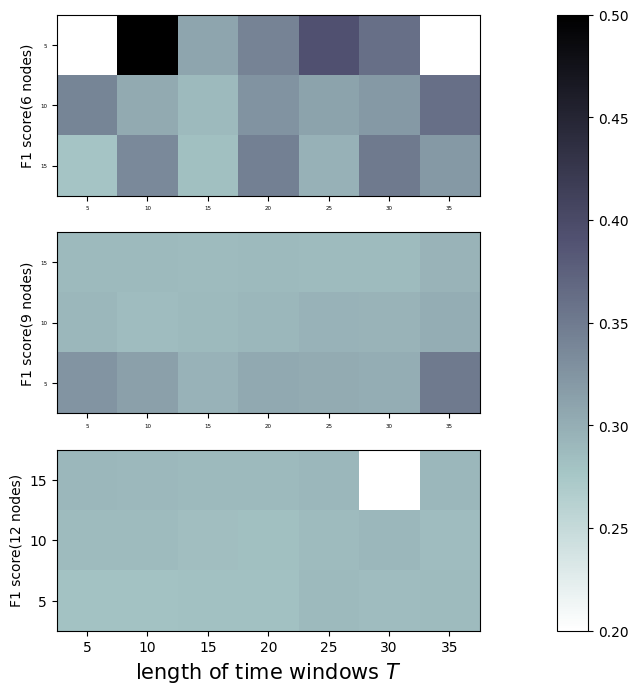

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,8))
c = axes[0].imshow(z0, cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max,
                interpolation ='nearest', origin ='upper')
#axes[0].set_xlabel('length of time windows '+r'$T$',fontsize=10)
axes[0].set_ylabel('F1 score(6 nodes)',fontsize=10)
positions = range(9)
labels=[5+i*5 for i in range(8)]
axes[0].yaxis.set_major_locator(ticker.FixedLocator(positions))
axes[0].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
for ytick in axes[0].get_yticklabels():
    ytick.set_fontsize(4)
axes[0].xaxis.set_major_locator(ticker.FixedLocator(positions))
axes[0].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
for xtick in axes[0].get_xticklabels():
    xtick.set_fontsize(4)

c = axes[1].imshow(z1, cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max,
                interpolation ='nearest', origin ='lower')
#axes[1].set_xlabel('length of time windows '+r'$T$',fontsize=10)
axes[1].set_ylabel('F1 score(9 nodes)',fontsize=10)
positions = range(9)
#labels=[r'$10^{-4}$',r'$10^{-4}\sqrt{10}$',r'$10^{-3}$',r'$10^{-3}\sqrt{10} $',r'$10^{-2}$',r'$10^{-2}\sqrt{10}$',r'$10^{-1}$',r'$10^{-1}\sqrt{10}$',r'$1$']
axes[1].yaxis.set_major_locator(ticker.FixedLocator(positions))
axes[1].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
for ytick in axes[1].get_yticklabels():
    ytick.set_fontsize(4)
    #ytick.set_rotation(45)
axes[1].xaxis.set_major_locator(ticker.FixedLocator(positions))
axes[1].xaxis.set_major_formatter(ticker.FixedFormatter(labels[:]))
for xtick in axes[1].get_xticklabels():
    xtick.set_fontsize(4)
    #xtick.set_rotation(45)

c = axes[2].imshow(z2, cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max,
                interpolation ='nearest', origin ='lower')
axes[2].set_xlabel('length of time windows '+r'$T$',fontsize=15)
axes[2].set_ylabel('F1 score(12 nodes)',fontsize=10)
positions = range(9)
#labels=[round(0.1*(i+1),1) for i in range(9)]
axes[2].yaxis.set_major_locator(ticker.FixedLocator(positions))
axes[2].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
for ytick in axes[0].get_yticklabels():
    ytick.set_fontsize(4)
axes[2].xaxis.set_major_locator(ticker.FixedLocator(positions))
axes[2].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
for xtick in axes[0].get_xticklabels():
    xtick.set_fontsize(4)

fig.colorbar(c, ax=axes.ravel().tolist())
plt.savefig('heatmap_combin_Nodes.pdf', bbox_inches='tight')

10
DataSize Nodes     10     15     20     25     30     35      5
0           12   0.28   0.28  0.282  0.282  0.288  0.286  0.287
1            6    0.2    0.5  0.308  0.341  0.392  0.361    0.2
2            9  0.325  0.313  0.296  0.305  0.302    0.3  0.351


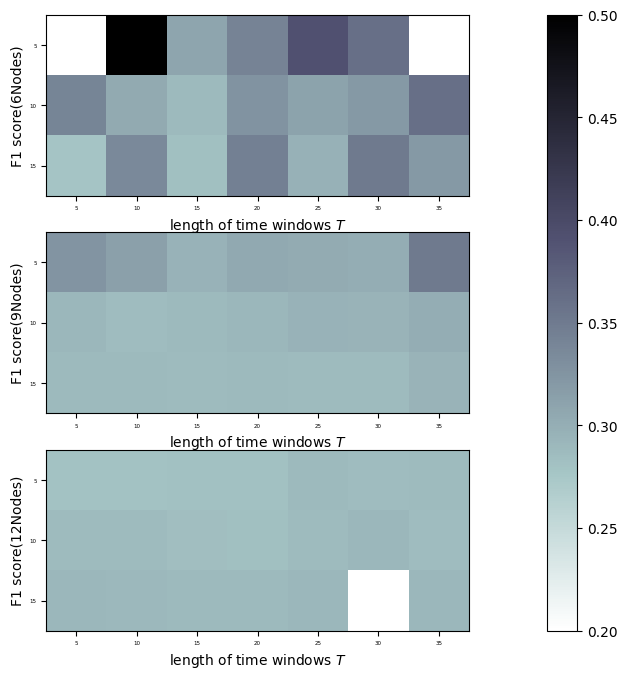

In [ ]:
import os
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def all_csv(File_PATH):
    #f1_anm_ncpop = pd.DataFrame([])
    f1_anm_ncpop = pd.DataFrame()
    tqdm=os.listdir(File_PATH)
    for i in range(0,len(tqdm)):
        files_path = os.path.join(File_PATH,tqdm[i])
        #entries = re.split("_", re.split("\.", tqdm[i])[0])
        entries = re.split("_",re.split("nodes_", re.split("\.", tqdm[i])[0])[0])
        ee = re.split("edges_",re.split("nodes_", re.split("\.", tqdm[i])[0])[1])[0]
        dd = re.split("D",re.split("edges_",re.split("nodes_", re.split("\.", tqdm[i])[0])[1])[1])[0]
        df = pd.read_csv(files_path)
        f1_anm_ncpop_nan = df.loc[:,'F1']
        if len([f1_anm_ncpop_nan == 0]) == len(f1_anm_ncpop_nan):
          f1_anm_ncpop_mean = 0.2
        else:
          f1_anm_ncpop_mean = round(np.nanmean(f1_anm_ncpop_nan), 3)
        f1_anm_ncpop = pd.concat((f1_anm_ncpop, pd.DataFrame(entries+[ee, dd, f1_anm_ncpop_mean])), axis=1)
    f1_result = pd.DataFrame(np.array(f1_anm_ncpop.T), columns=['Linear','Gauss','Nodes','Edges','DataSize','F1_Score'])
    group_obj = f1_result.groupby('Edges')#.agg('mean')
    for i in group_obj:
      print(i[0])
      f1_anm_ncpop_ = i[1].pivot(index='Nodes',columns='DataSize',values='F1_Score')
      f1_anm_ncpop_result = f1_anm_ncpop_.reset_index()
      print(f1_anm_ncpop_result)
      save_path='/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_Edges_'+str(i[0])
      f1_anm_ncpop_result.to_csv(save_path+".csv",index=False)
      np.save(save_path+".npy", f1_anm_ncpop_result)
      return f1_anm_ncpop_result

def Plots_ANM_NCPOP(z, type = 'Nodes', size = [6,9,12], start=5, stop=40, step=5 ):
    z_min=np.min(z)
    z_max=np.max(z)
        pro_rang = self.pro_rang
        obs_rang = self.obs_rang
    fig, axes = plt.subplots(nrows=len(z), ncols=1,figsize=(20,8))

    for i in range(len(z)):
      c = axes[i].imshow(z[i], cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max, interpolation ='nearest', origin ='upper')
      axes[i].set_xlabel('length of time windows '+r'$T$',fontsize=10)
      axes[i].set_ylabel('F1 score('+ str(size[i]) +type +')',fontsize=10)
      positions = range(9)
      labels=[5+i*5 for i in range(8)]
      axes[i].yaxis.set_major_locator(ticker.FixedLocator(positions))
      axes[i].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
      for ytick in axes[i].get_yticklabels():
          ytick.set_fontsize(4)
          #ytick.set_rotation(45)
      axes[i].xaxis.set_major_locator(ticker.FixedLocator(positions))
      axes[i].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
      for xtick in axes[i].get_xticklabels():
          xtick.set_fontsize(4)
          #xtick.set_rotation(45)

    fig.colorbar(c, ax=axes.ravel().tolist())
    plt.savefig('heatmap_combin_'+type+'.pdf', bbox_inches='tight')



if __name__ == "__main__":
  if type == 'Nodes':
    type = 'Nodes'
    size = [6,9,12]
    z = [z0, z1, z2]
    data = all_csv(File_PATH = '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results_Details/')
    for i in range(len(size)):
      read_path='/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_'+type+'_'+str(size[i]) +".csv"
      a=pd.read_csv(read_path,header=0,index_col=0)
      z[i]=a.to_numpy()
  else:

    '''Edges_10=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_Edges_10.csv",header=0,index_col=0)
    Edges_15=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_Edges_15.csv",header=0,index_col=0)
    Edges_20=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Result_Nonlinear/Results/Summary_Edges_20.csv",header=0,index_col=0)

    z0=Edges_10.to_numpy()
    z1=Edges_15.to_numpy()
    z2=Edges_20.to_numpy()'''
    rt = Plots_ANM_NCPOP(z, type = type, size = size, start=5, stop=40, step=5 )
rt


### Lines_Plot

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
###  Comparison for NCPOP  ###
labels3 = ['EM n=2', 'EM n=3', 'EM n=4']
colormap2 = ['#4292c6','#FF6347', '#696969']
colormap3 = ['#4292c6','#4292c6', '#4292c6']
colormap4 = ['#FF6347','#FF6347', '#FF6347']


# duration_time

fig = plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot2grid((1, 2), (0, 0))
width = 1
nx_range=np.array([10,20,30])

# 1st subplot
for m in range(4):
    if m == 3:
        x=nx_range+m*width
        y = ncpop_mean
        y_error = 1.96*ncpop_std[-1]/np.sqrt(5)
        ax1.plot(x,y, color=colormap[3],label='EM NCPOP')
        ax1.errorbar(x, y, yerr = y_error, fmt ='.', color=colormap[3],capsize=4,capthick=2) #,align='edge'
    else:
        x=nx_range+m*width
        y=em_bonmin_mean[:,m]
        y_error=1.96*em_bonmin_std[:,m]/np.sqrt(5)
        ax1.plot(x,y, color=colormap2[m],label=labels3[m])
        ax1.errorbar(x, y, yerr = y_error, fmt ='.', color=colormap2[m],capsize=4,capthick=2) #,align='edge'
    ax1.set_xticks(ticks=[10+width,20+width,30+width],labels=[10,20,30],fontsize=14)
    ax1.set_yticks(ticks=[0.0,0.25,0.5,0.75,1.0],labels=[0.0,0.25,0.5,0.75,1.0],fontsize=14)
ax1.set_ylabel('F1 score',fontsize=16)
ax1.set_xlabel('length of time windows '+r'$T$',fontsize=16)
plt.legend(fontsize=14,ncol=1,loc='lower right')

#2nd subplot
ax2 = plt.subplot2grid((1, 2), (0, 1))

for m in range(4):
    if m == 3:
        x = np.array([10,20,30])
        y=ncpop_duration
        ax2.plot(x,y, color=colormap[3],label='EM NCPOP')
    else:
        x = np.array([10,20,30])
        y = bonmin_duration[:,m]/5
        ax2.plot(x,y, color=colormap2[m],label=labels3[m])

    ax2.set_xticks(ticks=[10,20,30],labels=[10,20,30],fontsize=14)
    # ax3.set_yticks(ticks=[2,4,6],labels=[2,4,6],fontsize=14)
    # ax3.set_title('Subplot 3',fontsize=16)
    ax2.set_xlabel('length of time windows '+r'$T$',fontsize=16)
ax2.set_ylabel('average runtime for each iteration (s)',fontsize=16)
plt.legend(fontsize=14,loc='lower right')

axins = inset_axes(ax2, width="50%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.05, 0.4, 1, 1),
                   bbox_transform=ax2.transAxes)

for m in range(3):
    axins.plot(np.array([10,20,30]), bonmin_duration[:,m]/5, color=colormap2[m])
axins.set_xticks(ticks=[10,20,30],labels=[10,20,30])

plt.tight_layout()
plt.show()

In [ ]:
datai = 'linearGauss_6_15'
rawdata = np.load(datai+'.npz', allow_pickle=True)
data = rawdata['x'][:10]
print(data)
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.learn(data=data,causalmodelling='hidden_state1')


In [ ]:
import numpy as np
# from castle.algorithms.anm import ANMNonlinear
#np.random.seed(1)
x = np.random.rand(10, 3)
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.learn(data=x,causalmodelling='hidden_state1')


In [ ]:
f1_list_em_lds = []  # 5*10*3
# f1_test = np.zeros([3,50])
duration_em_lds = []

for n,data in enumerate(data_list):
    X_1 = data[:160].reshape(10,16,20,2)
    X_2 = data[160:].reshape(10,16,20,2)

    t_start = time.time()

    for i in range(10):
      xx_1 = X_1[i]
      xx_2 = X_2[i]
      xx_all = np.concatenate((xx_1,xx_2),axis=0)
      label = np.concatenate((np.zeros(16),np.ones(16)),axis=0)

      for j in range(5):
        f1 = EM_process(xx_all, label,'lds', 20, (n+2), 2, (30+i+j), MTS=True)
        # f1_test[n,(i*5+j)] = f1
        f1_list_em_lds.append(f1)
    duration_em_lds.append(time.time()-t_start)

In [ ]:
np.concatenate((np.zeros(5),np.ones(5)),axis=0)

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

In [ ]:
import sys
sys.path.append('../')
from copy import deepcopy
from sklearn.metrics import f1_score
from scipy.spatial.distance import pdist, squareform
import os
from scipy.io import arff
import time
import random
import matplotlib.pyplot as plt
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import pandas as pd

f1_list_ncpop_ecg = []
duration_ncpop_ecg = []

for t in [10,20,30]:
    for i in range(5):
        t_start = time.time()
        seed = i
        np.random.seed(seed+40)
        np.random.seed(seed)
        X = np.random.rand(10, 3)
        win_size =t
        s = random.sample(sorted(np.arange(140-win_size)),1)[0]
        X = X[:,s:(s+win_size)]
        print(s,X.shape)
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data=X,causalmodelling='hidden_state1')
        GraphDAG(anmNCPO.causal_matrix, true_dag, show=True)
        met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
        print('F1 Score is'+ str(met.metrics['F1'])+'.')

##################################################
        f1_list_ncpop_ecg.append(met.metrics['F1'])
        duration_ncpop_ecg.append(time.time()-t_start)

127 (10, 0)


NameError: ignored

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
import numpy as np
import os
#from castle.datasets import DAG, IIDSimulation
#from castle.algorithms import ANMNonlinear


df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
for nn in range(6,14,3):
  for ne in range(10,21,5):
    weighted_random_dag = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
    for ds in range(10,200,10):
      me = 'linear'
      dataset = IIDSimulation(W=weighted_random_dag, n=ds, self.method=me, sem_type='gauss')
      true_dag, data = dataset.B, dataset.X
      anmNCPO = ANM_NCPO(alpha=0.05)
      anmNCPO.learn(data=data,causalmodelling='hidden_state1')

      # plot predict_dag and true_dag
      sname = me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges_'+str(ds)+'DataSize'
      GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name='Result_' +sname)
      met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
      print(sname+ 'is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
      #mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
      df = pd.concat([df, pd.DataFrame([met.metrics])])
      df.to_csv(sname+'.csv', index=False)
  df1=df.assign(DataSize = ds)
  df1.to_csv('summary_' + me+ '_gauss_'+str(nn)+'nodes_'+str(ne)+'edges' +'.csv', index=False)
  #print(df1)

In [ ]:
#from castle.algorithms.ncpol._ncpol import NCPOLR,ANM_NCPO
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
#import numpy as np


rawdata = np.load('dataset/linear_gauss_6nodes_15edges.npz', allow_pickle=True)
DataSize = range(20,200,20)
#print(rawdata,DataSize,rawdata['x'])

#weighted_random_dag = DAG.erdos_renyi(n_nodes=3, n_edges=8, weight_range=(0.5, 2.0), seed=1)
#print(weighted_random_dag)
#dataset = IIDSimulation(W=weighted_random_dag, n=50, self.method='nonlinear', sem_type='gp-add')
true_dag, data = dataset.B, dataset.X
print(true_dag, data)

df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.learn(data=data)

# plot predict_dag and true_dag
GraphDAG(anmNCPO.causal_matrix, true_dag, show=True)
met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
print('Done!')
#mm = pd.DataFrame(pd.DataFrame([mm]).append([met.metrics]).dropna(axis = 0, how ='any'))#.drop_duplicates(inplace= True)
print(pd.DataFrame([met.metrics]))


AttributeError: ignored

In [ ]:
import numpy as np
from castle.algorithms.anm import ANMNonlinear
np.random.seed(1)
x = np.random.rand(500, 2)
anm = ANMNonlinear(alpha=0.05)
print(anm.anm_estimate(x[:, [0]], x[:, [1]]))

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import ANMNonlinear

weighted_random_dag = DAG.erdos_renyi(n_nodes=4, n_edges=10, weight_range=(0.5, 2.0), seed=1)
print(weighted_random_dag)
dataset = IIDSimulation(W=weighted_random_dag, n=1000, self.method='nonlinear', sem_type='gp-add')
true_dag, X = dataset.B, dataset.X
print(true_dag, X)
anm = ANMNonlinear(alpha=0.05)
anm.learn(data=X)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag)
mm = MetricsDAG(anm.causal_matrix, true_dag)
print(mm.metrics)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag, show=False, save_name='result')

#you can also provide more parameters to use it. like the flowing:
from sklearn.gaussian_process.kernels import Matern, RBF
kernel = Matern(nu=1.5)
# kernel = 1.0 * RBF(1.0)
anm = ANMNonlinear(alpha=0.05)
anm.learn(data=X, regressor=GPR(kernel=kernel))
# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag, show=False, save_name='result')

In [ ]:
print(mm.metrics)

In [ ]:
def load_from_npz(path, dataset):
  """Loads datasets from npz files."""
  file_name = path + dataset + '.npz'
  with np.load(open(file_name, 'rb'), allow_pickle=True) as loader:
    loader = dict(loader)
    adj_matrix = csr_matrix(
        (loader['adj_data'], loader['adj_indices'], loader['adj_indptr']),
        shape=loader['adj_shape'])

    if 'attr_data' in loader:
      # Attributes are stored as a sparse CSR matrix
      attr_matrix = csr_matrix(
          (loader['attr_data'], loader['attr_indices'], loader['attr_indptr']),
          shape=loader['attr_shape']).todense()
    elif 'attr_matrix' in loader:
      # Attributes are stored as a (dense) np.ndarray
      attr_matrix = loader['attr_matrix']
    else:
      raise Exception('No attributes in the data file', file_name)

    if 'labels_data' in loader:
      # Labels are stored as a CSR matrix
      labels = csr_matrix((loader['labels_data'], loader['labels_indices'],
                           loader['labels_indptr']),
                          shape=loader['labels_shape'])
      labels = labels.nonzero()[1]
    elif 'labels' in loader:
      # Labels are stored as a numpy array
      labels = loader['labels']
    else:
      raise Exception('No labels in the data file', file_name)

  return adj_matrix, attr_matrix, onehot(labels)

def onehot(labels):
  classes = set(labels)
  return jnp.identity(len(classes))[jnp.array(labels)]

from scipy.sparse import csr_matrix
load_from_npz('dataset/','linear_gauss_6nodes_15edges')

Test2